In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
df = pd.read_csv("../Customer_dashboard/data/data/tvod_svod_watchers.txt", sep="\t",
                names = ['first_TVOD_date','last_TVOD_date','encrypted_customer_id','first_SVOD_date','last_SVOD_date','distinct_SVOD_DSD'])

In [3]:
print(df.shape)
df.head()

(4000000, 6)


,first_TVOD_date,last_TVOD_date,encrypted_customer_id,first_SVOD_date,last_SVOD_date,distinct_SVOD_DSD
0,2014-05-02,2018-06-09,AKWWP4IN06KAW,2014-03-08,2018-07-01,145.0
1,2015-03-02,2018-07-20,A31QU3NVR4AG5X,2015-03-01,2018-07-21,504.0
2,2015-04-04,2018-02-17,A6UJRMSRD8FNY,NaN,NaN,NaN
3,2015-04-11,2016-07-17,A1HW0CX14BQGNQ,2014-08-21,2018-07-21,534.0
4,2015-09-11,2018-05-26,A1FBDWNT380YWF,2015-07-01,2018-07-18,207.0


In [4]:
df[df['first_SVOD_date'].isnull()].shape

(406735, 6)

In [5]:
def get_prep_dataset(df):
    df['first_TVOD_date'] = pd.to_datetime(df['first_TVOD_date'])
    df['last_TVOD_date'] = pd.to_datetime(df['last_TVOD_date'])
    df['first_SVOD_date'] = pd.to_datetime(df['first_SVOD_date'])
    df['last_SVOD_date'] = pd.to_datetime(df['last_SVOD_date'])
    
    df['tenure'] = (df['last_TVOD_date'].max() - df['first_TVOD_date']) / np.timedelta64(1,"D")
    df['is_SVOD_older'] = np.where(df['first_TVOD_date'] < df['first_SVOD_date'], 0 , 1)
    df['time_btw_first_TVOD_and_first_SVOD'] = (df['first_TVOD_date'] - df['first_SVOD_date']) / np.timedelta64(1,"D")
    
    #tenure rank for 
    #df['binned'] = pd.cut(df['tenure'], np.linspace(0,df['tenure'].max(),100))
    return df

In [6]:
df = get_prep_dataset(df)

In [7]:
df[0:10]

,first_TVOD_date,last_TVOD_date,encrypted_customer_id,first_SVOD_date,last_SVOD_date,distinct_SVOD_DSD,tenure,is_SVOD_older,time_btw_first_TVOD_and_first_SVOD
0,2014-05-02,2018-06-09,AKWWP4IN06KAW,2014-03-08,2018-07-01,145.0,1542.0,1,55.0
1,2015-03-02,2018-07-20,A31QU3NVR4AG5X,2015-03-01,2018-07-21,504.0,1238.0,1,1.0
2,2015-04-04,2018-02-17,A6UJRMSRD8FNY,NaT,NaT,NaN,1205.0,1,NaN
3,2015-04-11,2016-07-17,A1HW0CX14BQGNQ,2014-08-21,2018-07-21,534.0,1198.0,1,233.0
4,2015-09-11,2018-05-26,A1FBDWNT380YWF,2015-07-01,2018-07-18,207.0,1045.0,1,72.0
5,2016-01-15,2016-01-15,A1MPBHX229T17R,2015-10-26,2018-06-25,36.0,919.0,1,81.0
6,2016-02-14,2018-07-16,AUW66D4JD44UW,2014-04-02,2018-06-24,397.0,889.0,1,683.0
7,2016-02-28,2018-05-31,A2ZJ20FWP1QAPT,2014-08-14,2018-07-10,358.0,875.0,1,563.0
8,2016-03-12,2017-12-27,A3739J09YQG0M5,2014-12-13,2018-07-19,892.0,862.0,1,455.0
9,2016-04-01,2016-04-01,A12EU5ITEUKAV9,2015-06-27,2018-07-21,78.0,842.0,1,279.0


In [8]:
def get_overall_size(df):
    a = df[(df['distinct_SVOD_DSD'].notnull())].groupby(['is_SVOD_older']).size().reset_index()
    a.columns = ['is_SVOD_older','size']
    a['share'] = a['size'] / a['size'].sum()
    return a

In [9]:
sizes = get_overall_size(df)
sizes                       

,is_SVOD_older,size,share
0,0,392124,0.109127
1,1,3201141,0.890873


In [84]:
print(df[(df['distinct_SVOD_DSD'].notnull()) & (df['is_SVOD_older'] == 1)]['time_btw_first_TVOD_and_first_SVOD'].describe())
print(df[(df['distinct_SVOD_DSD'].notnull()) & (df['is_SVOD_older'] == 1)]['time_btw_first_TVOD_and_first_SVOD'].mean())
print(df[(df['distinct_SVOD_DSD'].notnull()) & (df['is_SVOD_older'] == 1)]['time_btw_first_TVOD_and_first_SVOD'].median())

count    3.201141e+06
mean     2.954924e+02
std      3.259353e+02
min      0.000000e+00
25%      4.000000e+01
50%      1.740000e+02
75%      4.490000e+02
max      1.607000e+03
Name: time_btw_first_TVOD_and_first_SVOD, dtype: float64
295.4924066137668
174.0


In [92]:
def by_tenure(df, metric):
    by_tenure = df[(df['distinct_SVOD_DSD'].notnull()) & (df['is_SVOD_older'] == 1)].groupby(metric)['time_btw_first_TVOD_and_first_SVOD'].median().reset_index()
    
    size = df[(df['distinct_SVOD_DSD'].notnull()) & (df['is_SVOD_older'] == 1)].groupby(metric).size().reset_index()
    size.columns = [metric,"size"]
    
    m = pd.merge(left = by_tenure, right = size, left_on = metric, right_on = metric, how = 'left' )
    m['ranked'] = np.arange(len(m.index)) // 360
    
    t1 = m.groupby("ranked")['size'].sum().reset_index()
    t2 = m.groupby("ranked")['time_btw_first_TVOD_and_first_SVOD'].mean().reset_index() #change to median if needed!
    
    t = pd.merge(left = t1, right = t2, left_on = 'ranked', right_on = 'ranked', how ='left')
    t['year_with_TVOD'] = t['ranked'] + 1
    return t,m

In [93]:
t,m = by_tenure(df, "tenure")
print(m['size'].sum())
print(m.shape)
m.head()

3201141
(1622, 4)


,tenure,time_btw_first_TVOD_and_first_SVOD,size,ranked
0,0.0,364.0,99,0
1,1.0,309.0,3016,0
2,2.0,314.0,1842,0
3,3.0,283.0,1417,0
4,4.0,291.0,1413,0


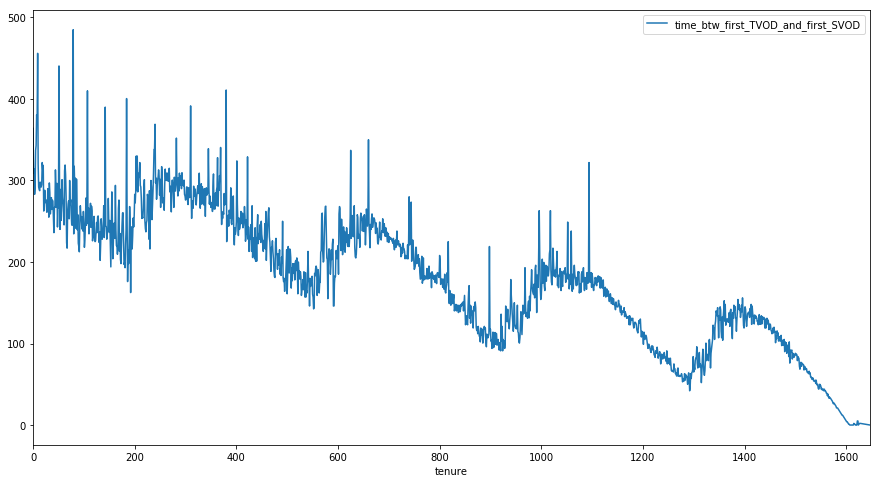

In [94]:
m.plot(x = 'tenure', y = 'time_btw_first_TVOD_and_first_SVOD',figsize = (15,8))

In [95]:
df[(df['distinct_SVOD_DSD'].notnull()) & (df['is_SVOD_older'] == 1) & (df['tenure'] == 0)]['time_btw_first_TVOD_and_first_SVOD'].median()

364.0

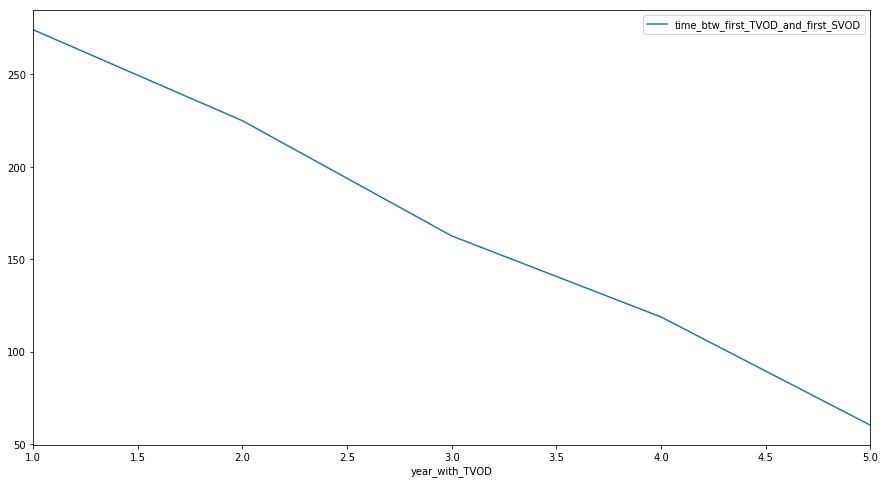

In [96]:
t.plot(x = 'year_with_TVOD', y = 'time_btw_first_TVOD_and_first_SVOD', figsize=(15,8))

In [97]:
t

,ranked,size,time_btw_first_TVOD_and_first_SVOD,year_with_TVOD
0,0,875196,274.083333,1
1,1,843016,224.906944,2
2,2,778861,162.650000,3
3,3,566815,118.854167,4
4,4,137253,60.365385,5


In [98]:
#Create dataframes according to rank
r4 = df[(df['distinct_SVOD_DSD'].notnull()) & (df['is_SVOD_older'] == 1) & (df['tenure'] >= m[m['ranked'] == 4]['tenure'].min())]
print(r4.shape)
r3 = df[(df['distinct_SVOD_DSD'].notnull()) & (df['is_SVOD_older'] == 1) & (df['tenure'] >= m[m['ranked'] == 3]['tenure'].min()) 
       & (df['tenure'] < m[m['ranked'] == 4]['tenure'].min())]
print(r3.shape)
r2 = df[(df['distinct_SVOD_DSD'].notnull()) & (df['is_SVOD_older'] == 1) & (df['tenure'] >= m[m['ranked'] == 2]['tenure'].min())
       & (df['tenure'] < m[m['ranked'] == 3]['tenure'].min())]
print(r2.shape)
r1 = df[(df['distinct_SVOD_DSD'].notnull()) & (df['is_SVOD_older'] == 1) & (df['tenure'] >= m[m['ranked'] == 1]['tenure'].min())
       & (df['tenure'] < m[m['ranked'] == 2]['tenure'].min())]
print(r1.shape)
r0 = df[(df['distinct_SVOD_DSD'].notnull()) & (df['is_SVOD_older'] == 1) & (df['tenure'] >= m[m['ranked'] == 0]['tenure'].min())
       & (df['tenure'] < m[m['ranked'] == 1]['tenure'].min())]
print(r0.shape)


(137253, 9)
(566815, 9)
(778861, 9)
(843016, 9)
(875196, 9)


In [99]:
r4.head()

,first_TVOD_date,last_TVOD_date,encrypted_customer_id,first_SVOD_date,last_SVOD_date,distinct_SVOD_DSD,tenure,is_SVOD_older,time_btw_first_TVOD_and_first_SVOD
0,2014-05-02,2018-06-09,AKWWP4IN06KAW,2014-03-08,2018-07-01,145.0,1542.0,1,55.0
78,2014-03-18,2018-04-10,A3JCPMDSEZYXK9,2014-02-27,2018-05-05,667.0,1587.0,1,19.0
79,2014-08-01,2017-09-09,A2NCQ3COHSNQ2I,2014-03-09,2018-07-19,544.0,1451.0,1,145.0
99,2014-07-18,2018-03-08,A3RVBWE912TDFN,2014-06-16,2018-07-17,240.0,1465.0,1,32.0
122,2014-08-08,2018-06-15,A5ZLMF03YSKEL,2014-03-19,2018-07-10,113.0,1444.0,1,142.0


In [83]:
# # Example
# from sklearn.datasets import load_iris

# iris = load_iris()
# iris = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
#                     columns=iris['feature_names'] + ['target'])

# # Sort the dataframe by target
# target_0 = iris.loc[iris['target'] == 0]
# target_1 = iris.loc[iris['target'] == 1]
# target_2 = iris.loc[iris['target'] == 2]

# sns.distplot(target_0[['sepal length (cm)']], hist=False, rug=True, label = "0")
# sns.distplot(target_1[['sepal length (cm)']], hist=False, rug=True, label = "1")
# sns.distplot(target_2[['sepal length (cm)']], hist=False, rug=True, label = "2")

# plt.legend()
# plt.show()

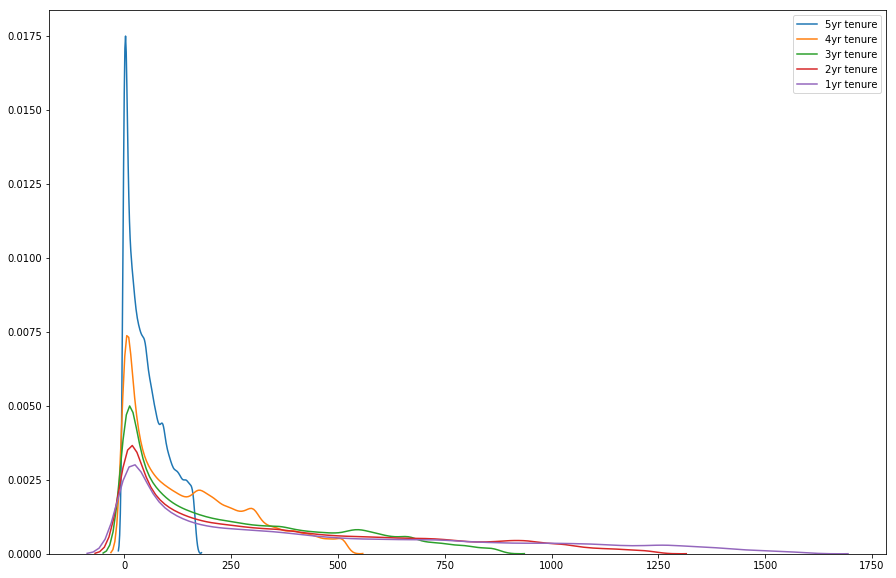

In [100]:
plt.figure(figsize = (15,10))
sns.distplot(r4[['time_btw_first_TVOD_and_first_SVOD']], hist = False, rug = False, label = '5yr tenure')
sns.distplot(r3[['time_btw_first_TVOD_and_first_SVOD']], hist = False, rug = False, label = '4yr tenure')
sns.distplot(r2[['time_btw_first_TVOD_and_first_SVOD']], hist = False, rug = False, label = '3yr tenure')
sns.distplot(r1[['time_btw_first_TVOD_and_first_SVOD']], hist = False, rug = False, label = '2yr tenure')
sns.distplot(r0[['time_btw_first_TVOD_and_first_SVOD']], hist = False, rug = False, label = '1yr tenure')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (15,10))

sns.distplot(r3[['time_btw_first_TVOD_and_first_SVOD']], hist = False, rug = False, label = '4yr tenure')
sns.distplot(r2[['time_btw_first_TVOD_and_first_SVOD']], hist = False, rug = False, label = '3yr tenure')
sns.distplot(r1[['time_btw_first_TVOD_and_first_SVOD']], hist = False, rug = False, label = '2yr tenure')
sns.distplot(r0[['time_btw_first_TVOD_and_first_SVOD']], hist = False, rug = False, label = '1yr tenure')


plt.legend()
plt.show()